
<div align='center'>
<font size="+2">
ML&DNN mod.2 - Exam

Ghiotto Alessandro 513944
</font>
</div>

---

We are given a dataset containing $186$ images which are categorized
into three classes, depending on the main object they contain. The following
inputs are available:

1. $\textit{input image}$, a $227 \times 227 \times 3$ real-valued tensor. The last dimension
denotes the number of input channels $(RGB)$. Each pixel is a value in
$[0, 255]$;
2. $\textit{image label}$, integer in the set ${1, 2, 3}$ denoting one of three possible
objects an image can contain. There are $63$, $62$, and $61$ images belonging
to the class $1$, $2$ and $3$, respectively;
3. $\textit{image bounding box}$, four integers $x_1$, $y_1$, $x_2$, $y_2$ in the range $1-227$, where
$(x_1, y_1)$ and $(x_2, y_2)$ are the bottom-left and the top-right corners of the
box containing the object, respectively.

Design a deep neural network model to predict the class of an image along
with the corresponding bounding box coordinates.

---

In [3]:
# DATA LOADING

import urllib.request
import zipfile
# ZIP data URL from GitHub
zip_url = "https://github.com/AlessandroGhiotto/CNN-image-classification/raw/main/input_data.zip"
# Download the ZIP
zip_path, _ = urllib.request.urlretrieve(zip_url)
# Unzip the folder
target_folder = "temp"
# reading data
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder)
data_path = f"{target_folder}/input_data.pkl"
# Then use the following lines to read it:
import pickle as pk
with open(data_path, 'rb') as f:
    data = pk.load(f)

images = data['imgs']
y = data['labels']
labels = y[:,0]
bboxes = y[:,1:]

In [ ]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K_backend
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import sparse_categorical_crossentropy, MeanSquaredError
from tensorflow.random import set_seed
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
import itertools
import time
import gc

# **2) INPUT**

**2a)** as Input I use the images, as target I use the labels and the bboxes

**2b)** Data preprocessing:

- scale the pixel values in the images: $[0, 255] \rightarrow [0,1]$
- scale the bboxes coordinates: $[1, 277] \rightarrow [0,1]$. Now we don't have anymore the coordinates of the bboxes, but instead a fraction of the width and of the height.
- **$\color{red}{\textbf{Change wrt exam:}}$ subtract by $\textbf{1}$ the labels : $\textbf{\{1, 2, 3\}} \rightarrow \textbf{\{0, 1, 2\}} \color{red}{\textbf{!!}}$**

> **I DON'T KEEP THE LABELS AS THEY ARE, I SUBTRACT THEM BY ONE, SINCE THE `sparse_categorical_crossentropy` LOSS FUNCTION IN KERAS REQUIRES LABELS TO BE IN THE RANGE $\mathbf{[0, num\_classes - 1]}$ (just for technical reasons, conceptually nothing changes).**

For scaling we just MinMaxScale the values, `x = (x - min)/(max - min)`

**2c)** The input samples of the model will be each row of the *'images'* numpy.array. The shape of one sample is $(227, 227, 3)$ and each pixel have values in $[0, 1]$

In [ ]:
# IMAGES
max = np.max(images)
min = np.min(images)
print(f'min pixel value: {min}, max pixel value: {max}')
# scale the pixel values
images = (images - min) / (max - min)
print(f'\nAfter the scaling:\nmin pixel value: {np.min(images)}, max pixel value: {np.max(images)}')
input_shape = images[0].shape
print(f'shape of one sample: {input_shape}')

min pixel value: 0.0, max pixel value: 255.0

After the scaling:
min pixel value: 0.0, max pixel value: 1.0
shape of one sample: (227, 227, 3)


In [ ]:
# BBOXES
max = np.max(bboxes)
min = np.min(bboxes)
print(f'min bbox coordinate value: {min}, max bbox coordinate value: {max}')
# scale the bboxes coordinatess
bboxes = (bboxes - min) / (max - min)
print(f'\nAfter the scaling:\nmin bbox: {np.min(bboxes)}, max bbox: {np.max(bboxes)}')
print(f'shape of one bbox: {bboxes[0].shape}')

min bbox coordinate value: 1, max bbox coordinate value: 227

After the scaling:
min bbox: 0.0, max bbox: 1.0
shape of one bbox: (4,)


In [ ]:
# LABELS
print(f'Original set of labels: {set(np.unique(labels))}')
labels = labels - 1
num_classes = len(np.unique(labels))
print(f'Our set of labels after subtracting them by one: {set(np.unique(labels))}')
print(f'shape of a label: {labels[0].shape}')

Original set of labels: {1, 2, 3}
Our set of labels after subtracting them by one: {0, 1, 2}
shape of a label: ()


**6)** Split between train and test with a ratio of $80:20$

In [ ]:
# Split the data into training and test sets (80% - 20%)
# stratify=labels to keep the same distribution of labels in the training and test sets

images_train, images_test, \
labels_train, labels_test, \
bboxes_train, bboxes_test = train_test_split(images, labels, bboxes, stratify=labels, shuffle=True, test_size=0.2, random_state=8)

print(f'images_train shape: {images_train.shape}')
print(f'labels_train shape: {labels_train.shape}')
print(f'bboxes_train shape: {bboxes_train.shape}')
print(f'images_test shape: {images_test.shape}')
print(f'labels_test shape: {labels_test.shape}')
print(f'bboxes_test shape: {bboxes_test.shape}')

images_train shape: (148, 227, 227, 3)
labels_train shape: (148,)
bboxes_train shape: (148, 4)
images_test shape: (38, 227, 227, 3)
labels_test shape: (38,)
bboxes_test shape: (38, 4)


We can take a look to how do our images looks like, and what our classes represents.

- class 0 $\rightarrow$ cucumber
- class 1 $\rightarrow$ eggplant
- class 2 $\rightarrow$ mushroom

Our objects are presented in different orientations, some with and others without background, and so on...

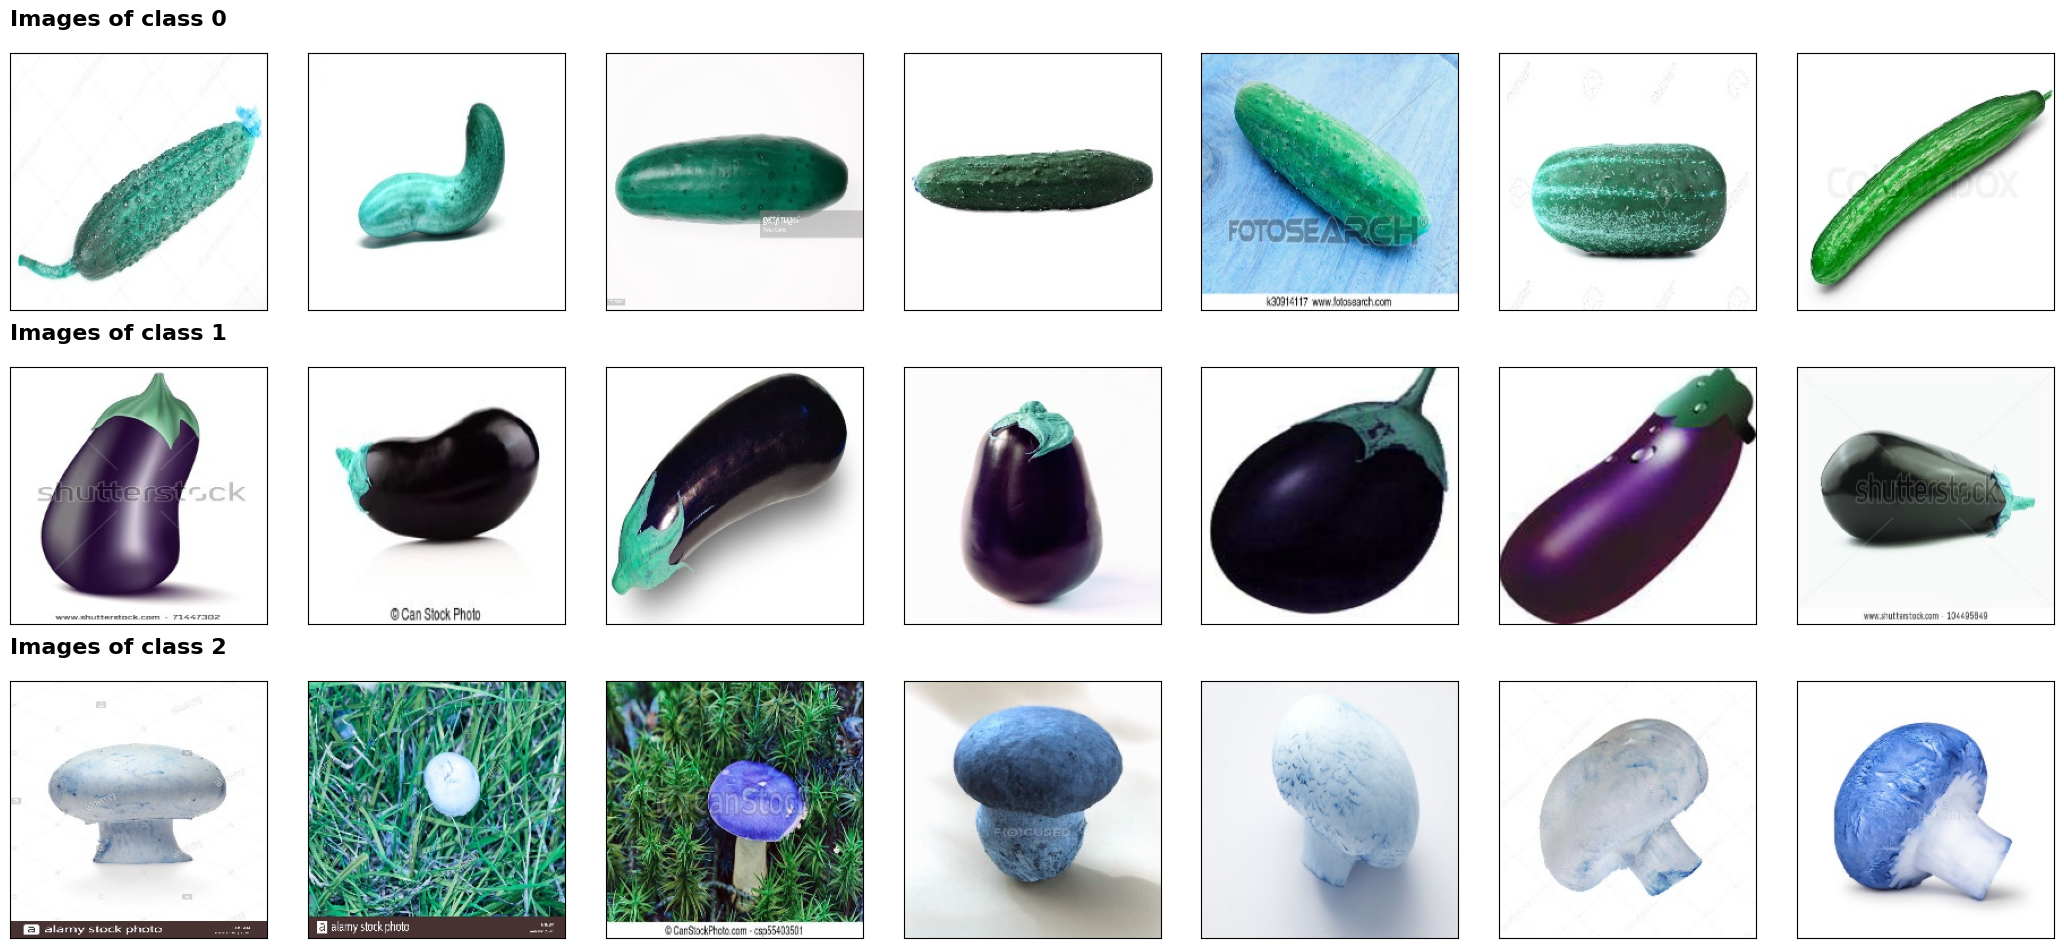

In [ ]:
imgs_class1 = images_train[labels_train == 0] # images of class 0
imgs_class2 = images_train[labels_train == 1] # images of class 1
imgs_class3 = images_train[labels_train == 2] # images of class 2

def plot_classes(imgs_class1=imgs_class1, imgs_class2=imgs_class2, imgs_class3=imgs_class3, n=7): # 7 images
    fig, axes = plt.subplots(nrows=3, ncols=n, figsize=(21, 9))
    for i in range(n):
        # Display class 0
        ax = axes[0, i]
        ax.imshow(imgs_class1[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display class 1
        ax = axes[1, i]
        ax.imshow(imgs_class2[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display class 2
        ax = axes[2, i]
        ax.imshow(imgs_class3[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    # set titles
    for row in range(3):
        axes[row, 0].set_title(f'Images of class {row}', loc='left', fontweight='bold', fontsize=16, pad=20)
    plt.tight_layout()
    plt.subplots_adjust(top=1)
    plt.show()

plot_classes()

---

# **5) MODEL CONFIGURATION**

### **Inception block**

A convolutional part constituted by inception blocks, followed by two classification heads.

The inception blocks can learn a multi-scale view of the input. With simple images conv layers should be enough, because at the end the true power of the inception blocks is seen with complex images. And also when we have many input channels as input, because $1\times1$ conv are used to collapse together different channels (so decreasing the dimension of the input).

Here we define a function for creating a `inception_block`, as a composition of keras layers.

**5b)** The Inception blocks use the **'ReLU'** activation function

**5c)** I use the **HeUniform** initializer for the convolutional layers

In [ ]:
# prev_layer: the previous layer (to which we will attach our layers)
# filters: numbers of filter to be used in each convolutional layer
#   -> len(filters) = 2
# kernelsize: size of the kernel to be used in each conv layer / maxpooling layer
#   -> len(kernelsize) = 3
# shrink_size: number of filters to be used in each 1x1 convolutional layer
#   -> len(shrink_size) = 3
# block_num: the number of the inception block
def inception_block(prev_layer, filters, kernel_size, shrink_size, block_num=0):
    '''
    This function creates an inception block.
    - 1st layer: [1x1 conv, conv layer]
    - 2nd layer: [1x1 conv, conv layer]
    - 3rd layer: [maxpooling, 1x1 conv]
    return: the concatenated output of the 3 layers
    '''

    ### 1st layer ###
    # 1x1 conv
    layer_1 = Conv2D(filters=shrink_size[0], kernel_size=(1,1), padding='same', activation='relu',
                     kernel_initializer=HeUniform(), name=f'block{block_num}_1x1_conv_1')(prev_layer)
    # conv layer
    f_size_1 = kernel_size[0]
    layer_1 = Conv2D(filters=filters[0], kernel_size=f_size_1, padding='same', activation='relu',
                     kernel_initializer=HeUniform(), name=f'block{block_num}_{f_size_1}x{f_size_1}_convA')(layer_1)

    ### 2nd layer ###
    # 1x1 conv
    layer_2 = Conv2D(filters=shrink_size[1], kernel_size=(1,1), padding='same', activation='relu',
                     kernel_initializer=HeUniform(), name=f'block{block_num}_1x1_conv_2')(prev_layer)
    # conv layer
    f_size_2 = kernel_size[1]
    layer_2 = Conv2D(filters=filters[1], kernel_size=f_size_2, padding='same', activation='relu',
                     kernel_initializer=HeUniform(), name=f'block{block_num}_{f_size_2}x{f_size_2}_convB')(layer_2)

    ### 3rd layer ###
    # maxpooling
    f_size_3 = kernel_size[2]
    layer_3 = MaxPooling2D(pool_size=f_size_3, strides=(1,1), padding='same',
                           name=f'block{block_num}_maxpool_{f_size_3}x{f_size_3}')(prev_layer)
    # 1x1 conv
    layer_3 = Conv2D(filters=shrink_size[2], kernel_size=(1,1), padding='same', activation='relu',
                     kernel_initializer=HeUniform(), name=f'block{block_num}_1x1_conv_3')(layer_3)

    ### 4th layer ### REMOVED FOR DECREASING THE NUMBER OF PARAMETERS (In particular for the dense layers after the Flatten)
    # 1x1 conv
    # layer_4 = Conv2D(filters=shrink_size[3], kernel_size=(1,1), padding='same', activation='relu',
    #                  kernel_initializer=HeUniform(), name=f'block{block_num}_1x1_conv_4')(prev_layer)

    ### output layer ###
    # concatenate the 3 layers
    mid = Concatenate(axis=3, name=f'block{block_num}_concat')([layer_1, layer_2, layer_3])
    return mid


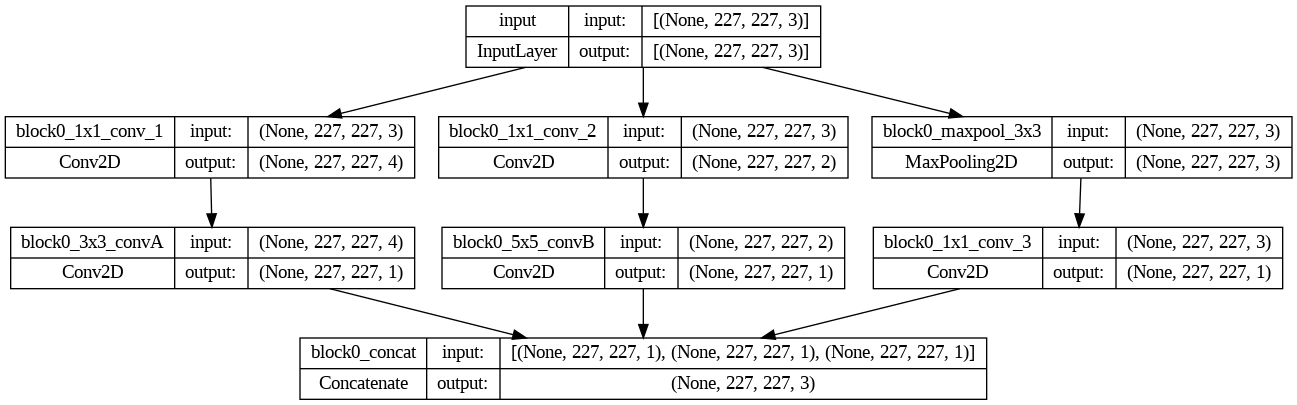

In [ ]:
# here we create a example just for looking at the inception block
input = Input(shape=(227, 227, 3), name='input')
output = inception_block(input, filters=[1, 1], kernel_size=[3, 5, 3], shrink_size=[4, 2, 1])
inception_example = Model(inputs=input, outputs=output)
plot_model(inception_example, show_shapes=True, show_layer_names=True)

Now I define a function for creating our model. For simplicity I will use the same parameters for all the inception blocks (if we have more of them), and also I will use the same number of neurons in both the dense layers (which precede the two outputs). In the inception blocks I will use a low number of output filters, so that I don't get too many parameters (and get MemoryErrors) for the Dense layers which receives as input the flattened output channels of the inception block.

**5a)** I start with the inception blocks, then flatten, then I split my model into two classification heads (each of them have two dense layers, of which one as output)

**5b)** As activation function I use the **'ReLU'**, in the Dense layer preceding the output layer

**5c)** As a form of regularization I add two **dropout** layers (one for each head, between the two dense layers)

**5d)** As params of my function I include the number of inception blocks (*n_inception_blocks*) and the dropout rate (*dropout_rate*), since I have specified them as object of optimization

### **3) OUTPUT:**

- *'output_label'* : `Dense(n_classes, activation='softmax')` $\rightarrow$ probability distribution over the $3$ classes
- *'output_bbox'*  : `Dense(4, activation='sigmoid')` $\rightarrow$ predict a value in $[0, 1]$ for each coordinate of the corners of the bbox

In [ ]:
# filters, kernel_size, shrink_size : params of the inception block
# dense_size: size of the dense layers (in the classification heads)
# n_inception_blocks: number of inception blocks to be created
def create_model(filters=[1, 1],
                 kernel_size=[3, 5, 3],
                 shrink_size=[8, 2, 1],
                 dense_size=32,
                 dropout_rate=0.2,
                 n_inception_blocks=1,
                 input_shape=(227, 227, 3),
                 n_classes=3,
                 len_bbox=4):

    ### Input layer
    input_img = Input(shape=input_shape, name='input_img')

    ### Inception blocks
    # we will create n_inception_blocks inception blocks
    for i in range(n_inception_blocks):
        input_layer = input_img if i == 0 else inception # the input is the input_img or the previous inception block
        inception = inception_block(input_layer, filters, kernel_size, shrink_size, block_num=i)

    ### Flatten the output of the last inception block
    flat = Flatten(name='flatten')(inception)

    ### classification head 1 - label
    dense_1 = Dense(dense_size, activation='relu', name='dense_label')(flat)
    dr1 = Dropout(dropout_rate, name='dr_label')(dense_1)
    # output label -> softmax with n_classes
    # name='output_label' is important for the fit
    output_1 = Dense(n_classes, activation='softmax', name='output_label')(dr1)

    ### classification head 2 - bbox
    dense_2 = Dense(dense_size, activation='relu', name='dense_bbox')(flat)
    dr2 = Dropout(dropout_rate, name='dr_bbox')(dense_2)
    # output bbox -> sigmoid with 4 neurons
    # name='output_bbox' is important for the fit
    output_2 = Dense(len_bbox, activation='sigmoid', name='output_bbox')(dr2)

    model = Model(
        inputs=[input_img],
        outputs=[output_1, output_2],
        name='inception_model'
    )
    return model

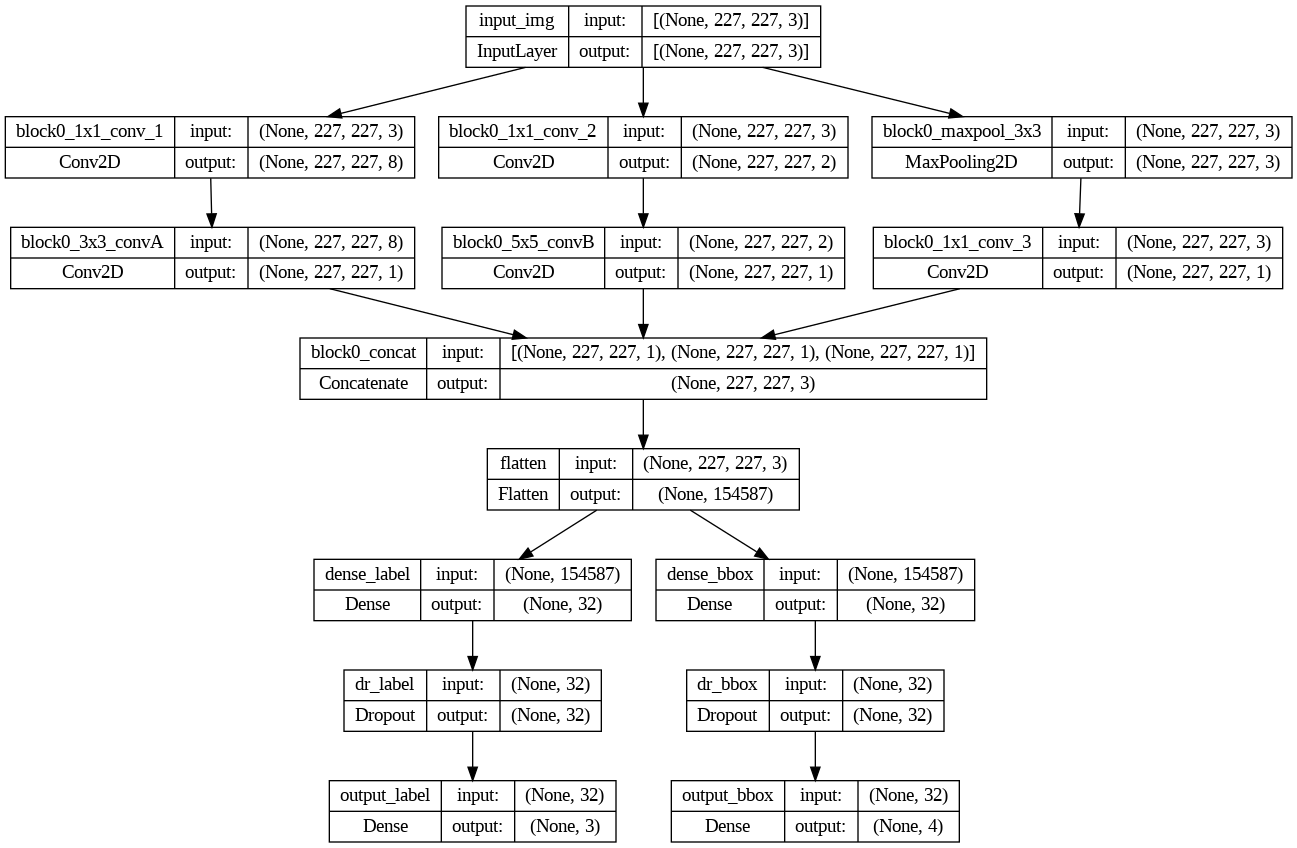

In [ ]:
# Plot of our full model
model_example = create_model(filters=[1, 1], kernel_size=[3, 5, 3], shrink_size=[8, 2, 1], dense_size=32, n_inception_blocks=1)
plot_model(model_example, show_shapes=True, show_layer_names=True)

## **COMPILING THE MODEL:**

### **4) LOSS:**

I specify a dictionary of two losses, as keys I use the names that I have used for the two outputs layers

- *'output_label'* : `sparse_categorical_crossentropy` $\rightarrow$ minimize KL divergence between predicted label and true label on the classes $\{0, 1, 2\}$ (for the softmax output)
- *'ouput_bbox'*  : `MeanSquaredError()` $\rightarrow$ decrease the mean squared distance between the predicted coordinates of the bboxes and the true coordinates (regression in $[0, 1]$ since I have used the sigmoid as output)

### **6) METRICS:**

> **I FORGOT TO SPECIFY IN THE EXAM THAT WE USE THE MSE ALSO AS METRIC FOR THE BBOXES (NOT JUST AS LOSS)**

I specify a dictionay of metrics, in the same way as with the losses

- *'output_label'* : `'accuracy'` (multiclass classification)
- *'ouput_bbox'*  : `MeanSquaredError()` (regression)


**TRAINING:**

I need to be careful on specifying well the two output (by using a dictionary containing as keys the names of the two output layers)

- *'output_label'* : `labels_train`
- *'output_bbox'* : `bboxes_train`

(As optimizer I will use the `Adam` optimizer with learning rate of $10^{-4}$)

In [ ]:
def DefineModelAndTrain(
        filters=[1, 1],
        kernel_size=[3, 5, 3],
        shrink_size=[8, 2, 1],
        dense_size=32,
        dropout_rate=0.2,
        n_inception_blocks=1,
        input_shape=(227, 227, 3),
        n_classes=3,
        learning_rate=10**-4,
        batch_size=16,
        epochs=100,
        images_train=images_train,
        labels_train=labels_train,
        bboxes_train=bboxes_train,
        validation_data=None,
        seed=8,
        verbose=0,
        ):
    # set the seed
    np.random.seed(seed)
    set_seed(seed)

    # create the model
    model = create_model(filters, kernel_size, shrink_size, dense_size, dropout_rate, n_inception_blocks, input_shape, n_classes)

    # compile the model
    # LOSS: composed loss (the names in the dictionary must match the names of the outputs layers)
    # METRICS: corresponding metrics
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss={'output_label': sparse_categorical_crossentropy,
              'output_bbox': MeanSquaredError()},
        metrics={'output_label': 'accuracy',
                 'output_bbox': MeanSquaredError()},
    )

    # fit the model (I need to pass the labels and the bboxes in the y parameter as a dictionary)
    history = model.fit(
        x=images_train,
        y={'output_label': labels_train,
           'output_bbox' : bboxes_train},
        validation_data=validation_data,
        epochs=epochs,
        batch_size=batch_size,
        verbose=verbose
    )

    # return the trained model and the history
    return model, history

# **6) MODEL EVALUATION**

I apply cross validation on the train set (which I have already created and constitute $80\%$ of the original dataset)

I split the train set in just three folds (`StratifiedKFold(n_splits=3)`), and I define my Grid search over the selected parameters.

**5d)** On which hyperparameters I perform the model selection:

1. *'n_inception_blocks'* : $[1, 2]$
2. *'batch_size'* : $[16, 32]$
3. *'dropout_rate'* : $[0.0, 0.2]$

Then for the other hyperparameters I use the following values (which are set as default in the `DefineModelAndTrain` function):

- *'filters'* = $[1, 1]$ (number of filters to be used in the Convolutional layer)
- *'kernel_size'* = $[3, 5, 3]$ (kernel size to be used in each Convolutional / Maxpooling layer)
- *'shrink_size'* = $[8, 2, 1]$, (number of filters to be used in each $1\times1$ Convolutional layer)
- *'dense_size'* = $32$, (number of neurons in the two Dense layers)
- *'learning_rate'* = $10^{-4}$, (while trying I have seen that a learning rate higher than this makes difficult learning to predict the bboxes)
- *'epochs'* = $100$,


In [ ]:
# Define the hyperparameters possible values
n_inception_blocks = [1, 2]
batch_size = [16, 32]
dropout_rate = [0.0, 0.2]

# StratifiedKFold with 3 splits
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=8)
top_configs = [] # save the best configuration for each fold
labels_accuracy = [] # with the corresponding accuracy on test set
bboxes_mse = [] # and mse

# 3-fold cross-validation
for i, (train_idx, val_idx) in enumerate(skf.split(images_train, labels_train)):
    # take the data for the fold, given by the corresponding indexes from the StratifiedKFold
    images_data, labels_data, bboxes_data = images_train[train_idx,:], labels_train[train_idx], bboxes_train[train_idx,:]
    images_val, labels_val, bboxes_val = images_train[val_idx,:], labels_train[val_idx], bboxes_train[val_idx,:]

    # create the GridSearch -> all possible combinations
    # a configuration = [n_inception_blocks, batch_size, dropout_rate]
    configs = itertools.product(n_inception_blocks, batch_size, dropout_rate) # create the iterator for each fold

    print('FOLD NUMBER:', i)
    max_accuracy = -1
    max_accuracy_model_config, max_mse, best_model = None, None, None
    # for each configuration
    for config in configs:
        t0 = time.time()
        # create our model and train it with the current configuration, on the current fold of data
        model, _ = DefineModelAndTrain(n_inception_blocks=config[0], batch_size=config[1], dropout_rate=config[2],
                                       images_train=images_data, labels_train=labels_data, bboxes_train=bboxes_data)
        t1 = time.time()
        pred_label, pred_bbox = model.predict(images_val, verbose=0) # predict the labels and the bboxes on the validation set
        acc = accuracy_score(labels_val, np.argmax(pred_label, axis=1)) # compute the accuracy on validation set
        mse = np.mean((bboxes_val - pred_bbox)**2) # compute the mse on validation set
        print(f"(n_inception_blocks, batch_size, dropout_rate): {config} -> acc: {round(acc, 3)}, mse: {round(mse, 3)}, time: {int(round(t1-t0, 0))}s")
        if acc > max_accuracy: # store the config with higher accuracy
            max_accuracy, max_mse, max_accuracy_model_config, best_model = acc, mse, config, model

        # Clear Keras session and delete the model to free up memory
        K_backend.clear_session()
        del model
        gc.collect()

    # evaluate the best model of this fold on the test set
    pred_label_test, pred_bbox_test = best_model.predict(images_test, verbose=0)
    acc_test = accuracy_score(labels_test, np.argmax(pred_label_test, axis=1))
    mse_test = np.mean((bboxes_test - pred_bbox_test)**2)
    print(f"[FOLD {i}] Best configuration -> (n_inception_blocks, batch_size, dropout_rate): {max_accuracy_model_config}")
    print(f"[FOLD {i}] accuracy on test: {acc_test}, mse on test: {mse_test}")
    print('--'*40)
    # save the results
    top_configs.append(max_accuracy_model_config)
    labels_accuracy.append(acc_test)
    bboxes_mse.append(mse_test)

    # Clear Keras session and delete the model to free up memory
    K_backend.clear_session()
    del best_model
    gc.collect()


FOLD NUMBER: 0
(n_inception_blocks, batch_size, dropout_rate): (1, 16, 0.0) -> acc: 0.82, mse: 0.045, time: 23s
(n_inception_blocks, batch_size, dropout_rate): (1, 16, 0.2) -> acc: 0.76, mse: 0.013, time: 22s
(n_inception_blocks, batch_size, dropout_rate): (1, 32, 0.0) -> acc: 0.34, mse: 0.045, time: 13s
(n_inception_blocks, batch_size, dropout_rate): (1, 32, 0.2) -> acc: 0.66, mse: 0.045, time: 22s


(n_inception_blocks, batch_size, dropout_rate): (2, 16, 0.0) -> acc: 0.74, mse: 0.013, time: 23s


(n_inception_blocks, batch_size, dropout_rate): (2, 16, 0.2) -> acc: 0.84, mse: 0.011, time: 23s
(n_inception_blocks, batch_size, dropout_rate): (2, 32, 0.0) -> acc: 0.78, mse: 0.01, time: 23s
(n_inception_blocks, batch_size, dropout_rate): (2, 32, 0.2) -> acc: 0.32, mse: 0.045, time: 17s
[FOLD 0] Best configuration -> (n_inception_blocks, batch_size, dropout_rate): (2, 16, 0.2)
[FOLD 0] accuracy on test: 0.8947368421052632, mse on test: 0.008202023818142912
--------------------------------------------------------------------------------
FOLD NUMBER: 1
(n_inception_blocks, batch_size, dropout_rate): (1, 16, 0.0) -> acc: 0.551, mse: 0.037, time: 22s
(n_inception_blocks, batch_size, dropout_rate): (1, 16, 0.2) -> acc: 0.755, mse: 0.012, time: 22s
(n_inception_blocks, batch_size, dropout_rate): (1, 32, 0.0) -> acc: 0.898, mse: 0.041, time: 12s
(n_inception_blocks, batch_size, dropout_rate): (1, 32, 0.2) -> acc: 0.816, mse: 0.041, time: 13s
(n_inception_blocks, batch_size, dropout_rate): (

In [ ]:
best_config = top_configs[np.argmax(labels_accuracy)] # take the best config (between the 3 best configs, one for each fold)
print(f'The best configuration is: {best_config}')
print(f'With an accuracy on test set of: {labels_accuracy[np.argmax(labels_accuracy)]}')
print(f'And a mse on test set of: {bboxes_mse[np.argmax(labels_accuracy)]}')

The best configuration is: (1, 32, 0.0)
With an accuracy on test set of: 0.9473684210526315
And a mse on test set of: 0.04450553040370475


# **BEST MODEL**

Now we train a model with the best configuration on the whole train set

In the model selection part we have found as configuration with higher accuracy the following one:

1. *'n_inception_blocks'* : $1$
2. *'batch_size'* : $32$
3. *'dropout_rate'* : $0.0$

Now we retrain it on the whole training data, and we test it on the test set.

In [ ]:
# take the hyperparameters from the best configuration
n_inception_blocks = best_config[0]
batch_size = best_config[1]
dropout_rate = best_config[2]
# other hyperparameters
epochs = 100
learning_rate = 10**-4
verbose = 1

# train the model with the best configuration
# I use the test set as validation data just for looking at the whole learning curve
best_model, best_model_history = DefineModelAndTrain(
    n_inception_blocks=n_inception_blocks, batch_size=batch_size, dropout_rate=dropout_rate, # best configuration
    epochs=epochs, learning_rate=learning_rate, verbose=verbose, # other hyperparameters
    images_train=images_train, labels_train=labels_train, bboxes_train=bboxes_train, # all the training data
    validation_data=(images_test, {'output_label': labels_test, 'output_bbox': bboxes_test}) # validation data (test set)
)

Epoch 1/100
5/5 [==============================] - 4s 316ms/step - loss: 1.1136 - output_label_loss: 1.0672 - output_bbox_loss: 0.0465 - output_label_accuracy: 0.4730 - output_bbox_mean_squared_error: 0.0448 - val_loss: 0.7306 - val_output_label_loss: 0.7047 - val_output_bbox_loss: 0.0259 - val_output_label_accuracy: 0.6842 - val_output_bbox_mean_squared_error: 0.0247
Epoch 2/100
5/5 [==============================] - 0s 54ms/step - loss: 0.6498 - output_label_loss: 0.6237 - output_bbox_loss: 0.0261 - output_label_accuracy: 0.7095 - output_bbox_mean_squared_error: 0.0258 - val_loss: 0.6795 - val_output_label_loss: 0.6526 - val_output_bbox_loss: 0.0268 - val_output_label_accuracy: 0.6316 - val_output_bbox_mean_squared_error: 0.0257
Epoch 3/100
5/5 [==============================] - 0s 53ms/step - loss: 0.5200 - output_label_loss: 0.4948 - output_bbox_loss: 0.0252 - output_label_accuracy: 0.7770 - output_bbox_mean_squared_error: 0.0257 - val_loss: 0.5767 - val_output_label_loss: 0.5507 -

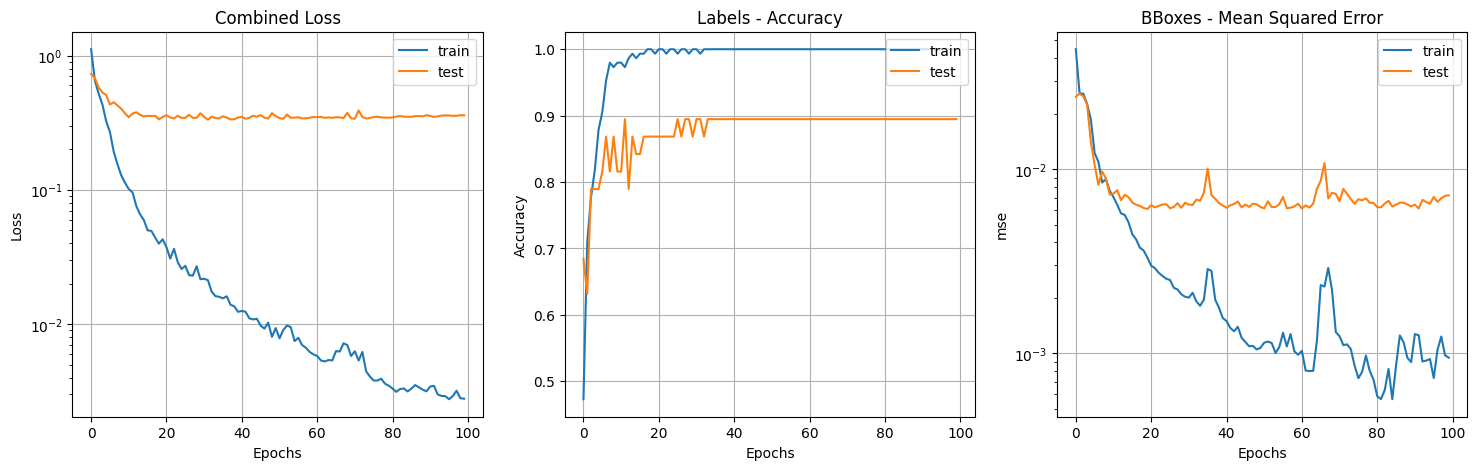

In [ ]:
def display_learning_curves(history):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # plot the loss
    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.set_title("Combined Loss")
    ax1.grid(True)
    ax1.set_yscale('log')

    # plot the accuracy metric
    ax2.plot(history.history["output_label_accuracy"])
    ax2.plot(history.history["val_output_label_accuracy"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.set_title("Labels - Accuracy")
    ax2.grid(True)

    # plot the mse metric
    ax3.plot(history.history["output_bbox_mean_squared_error"])
    ax3.plot(history.history["val_output_bbox_mean_squared_error"])
    ax3.legend(["train", "test"], loc="upper right")
    ax3.set_xlabel("Epochs")
    ax3.set_ylabel("mse")
    ax3.set_title("BBoxes - Mean Squared Error")
    ax3.grid(True)
    ax3.set_yscale('log')

    plt.show()

display_learning_curves(best_model_history)

Get the prediction on the test set

In [ ]:
pred_label_test, pred_bbox_test = best_model.predict(images_test, verbose=0)
pred_label_test = np.argmax(pred_label_test, axis=1)
acc_test = accuracy_score(labels_test, pred_label_test)
mse_test = np.mean((bboxes_test - pred_bbox_test)**2)
print(f'accuracy on test set: {acc_test}')
print(f'mse on test set: {mse_test}')

accuracy on test set: 0.8947368421052632
mse on test set: 0.010299303145213346


## Visualizing the result

At the beginning I have transformed the bboxes from integers in $[1, 277]$ to values in $[0, 1]$.

Now I want to visualize the bboxes, so from the prediction in $[0, 1]$, I go back to the values in $[1, 277]$

In the plots belows, the green box correspond to the true bbox, the dashed-red box correspond to the predicted bbox.

In [ ]:
# inverse of the MinMaxScaling
min, max = 1, 227
pred_bbox_coords = np.round(pred_bbox_test * (max - min) + min).astype(int)
true_bbox_coords = np.round(bboxes_test * (max - min) + min).astype(int)
print(f'predicted bbox coordinates:\n{pred_bbox_coords[:5]}')

predicted bbox coordinates:
[[ 43  35 169 152]
 [ 23  35 200 175]
 [ 45  44 171 186]
 [109  10 170 218]
 [ 30  45 178 169]]


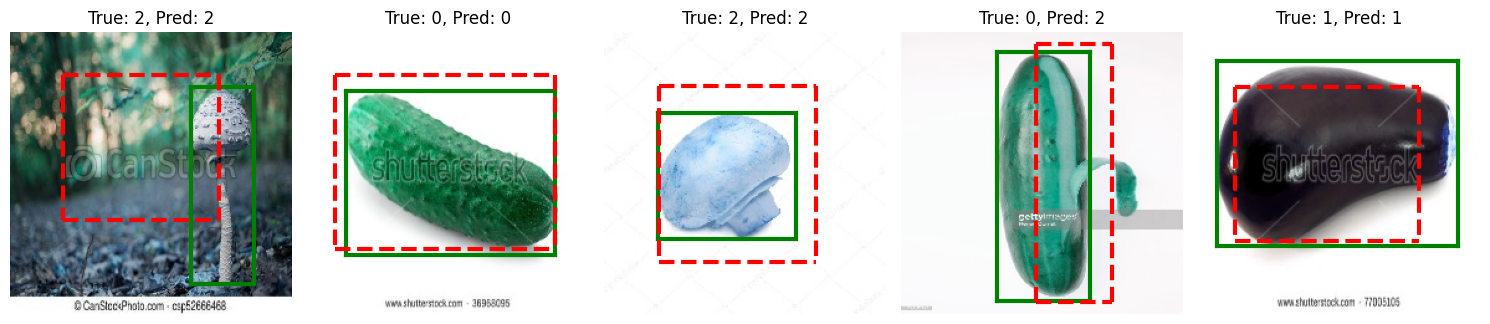

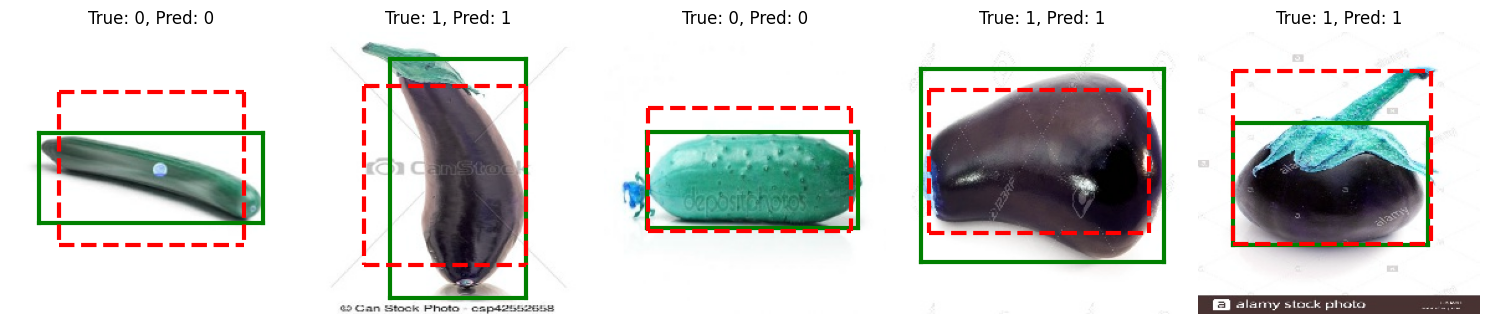

In [ ]:
def plot_images_with_bboxes(images, true_bboxes, true_labels, pred_bboxes=None, pred_labels=None, line_width=3):
    """
    Plots the given images and draws the true and predicted bounding boxes.
    true bbox -> green
    predicted bbox -> dashed red

    Args:
    - images: numpy array of shape (n_images, 227, 227, 3)
    - true_bboxes: numpy array of shape (n_images, 4), each containing [x1, y1, x2, y2] for true bounding box
    - pred_bboxes: numpy array of shape (n_images, 4), each containing [x1, y1, x2, y2] for predicted bounding box
    """
    n_images = len(images)
    fig, axes = plt.subplots(1, n_images, figsize=(15, 5))

    # the coordinates starts from the first pixel, but in matplotlib we start from 0
    true_bboxes = true_bboxes - 1
    pred_bboxes = pred_bboxes - 1

    if n_images == 1:
        axes = [axes]  # ensure axes is a list even if there's only one image

    # for each image
    for i, ax in enumerate(axes):
        # display the image
        ax.imshow(images[i])
        # set the title
        if pred_labels is not None:
            ax.set_title(f'True: {true_labels[i]}, Pred: {pred_labels[i]}', fontsize=12)
        else:
            ax.set_title(f'True: {true_labels[i]}', fontsize=12)

        # Draw true bounding box
        if true_bboxes[i] is not None:
            x1, y1, x2, y2 = true_bboxes[i] # extract the coordinates
            ax.plot([x1, x1], [y1, y2], color='green', linewidth=line_width)  # Left vertical line
            ax.plot([x2, x2], [y1, y2], color='green', linewidth=line_width)  # Right vertical line
            ax.plot([x1, x2], [y1, y1], color='green', linewidth=line_width)  # Bottom horizontal line
            ax.plot([x1, x2], [y2, y2], color='green', linewidth=line_width)  # Top horizontal line

        # Draw predicted bounding box
        if pred_bboxes is not None and pred_bboxes[i] is not None:
            x1, y1, x2, y2 = pred_bboxes[i] # extract the coordinates
            ax.plot([x1, x1], [y1, y2], color='red', linestyle='dashed', linewidth=line_width)  # Left vertical line
            ax.plot([x2, x2], [y1, y2], color='red', linestyle='dashed', linewidth=line_width)  # Right vertical line
            ax.plot([x1, x2], [y1, y1], color='red', linestyle='dashed', linewidth=line_width)  # Bottom horizontal line
            ax.plot([x1, x2], [y2, y2], color='red', linestyle='dashed', linewidth=line_width)  # Top horizontal line

        ax.axis('off')

    plt.tight_layout()
    plt.show()

# plot the first n_images in the test
n_images = 5
plot_images_with_bboxes(images_test[:n_images], true_bbox_coords[:n_images], labels_test[:n_images],
                        pred_bbox_coords[:n_images], pred_label_test[:n_images])
# plot the second n_images in the test
plot_images_with_bboxes(images_test[n_images:2*n_images], true_bbox_coords[n_images:2*n_images], labels_test[n_images:2*n_images],
                        pred_bbox_coords[n_images:2*n_images], pred_label_test[n_images:2*n_images])